In [36]:
import wave as wave
import numpy as np
import pyroomacoustics as pa
import scipy.signal as sp
import matplotlib.pyplot as plt

def calculate_steering_vector(mic_alignments, source_locations, freqs, sound_speed=340, is_use_far=True):
    """
    mic_alignments: 3xM ndarray [[x, y, z], [x, y, z]] (書籍内でのd_mやd_nに相当)
    source_locations: 3xN_s ndarray [[x, y, z], [x, y, z]] （書籍内でのpに相当）
        恐らくだが、[[x_1, x_2], [y_1, y_2], [z_1, z_2]] の方が正しい
    freqs: 1xNk array
    sound_speed: 音速 [m/s]
    is_use_far: Farを使う場合はTrue, Nearの場合はFalse
    return: steering vector(Nk x Ns x M)
    """
    n_channels = np.shape(mic_alignments)[1]
    print(n_channels)

    if is_use_far == True:
        norm_source_locations = source_locations/np.linalg.norm(source_locations, 2, axis=0, keepdims=True)

        steering_phase = np.einsum('k,ism,ism->ksm', 2.j*np.pi/sound_speed*freqs, norm_source_locations[..., None], mic_alignments[:, None, :])
        steering_vector = 1./np.sqrt(n_channels)*np.exp(steering_phase)

        return steering_vector
    
    # is_use_far == Falseの場合は実装していない

def display_DSBF_spectrum(stft_data: np.ndarray, far_steering_vectors, start_angle: float, end_angle: float, divisions: int, frame_num: int):
    """
    stft_data: T x Nk ndarray ()
    far_steering_vectors: Nk x Ns x M (Nsは音源方向数)
    frame_num: 時間平均を取るフレーム数
    """
    spectrum = np.empty((0, far_steering_vectors.shape[1]))
    stft_data_inv = np.transpose(stft_data, axes=(1, 0, 2)).conj()

    # frame_numごとに時間平均をとり、空間スペクトルを算出
    set_index = 1
    while True:
        mean_start_index = (set_index-1)*frame_num
        mean_end_index = set_index*frame_num
        
        if mean_start_index >= stft_data.shape[2]:
            break
        if mean_end_index > stft_data.shape[2]:
            mean_end_index = stft_data.shape[2]
        
        zz = np.einsum("mkt,knt->kmn", stft_data[:, :, mean_start_index:mean_end_index], stft_data_inv[:, :, mean_start_index:mean_end_index]) / frame_num
        # とりあえず全周波数ビンで和を取ることにしたが、正しい算出方法はわからない
        temp_spectrum = np.einsum("ksm,kmn,ksn->s", far_steering_vectors.conj(), zz, far_steering_vectors)/np.einsum("ksm,ksn->s", far_steering_vectors.conj(), far_steering_vectors)
        
        spectrum = np.append(spectrum, [abs(temp_spectrum)], axis=0)
        set_index += 1
    plt.imshow(spectrum.T, interpolation="nearest", aspect="auto", extent=[0, spectrum.shape[0], start_angle, end_angle])
    plt.colorbar()
    plt.ylabel("Direction of Arrival")
    plt.xlabel("Time [frame]")
    plt.show()
    


def write_file_from_time_signal(signal,file_name,sample_rate):
    """
    2バイトに変換してファイルに保存
    signal: time-domain 1d array (float)
    file_name: 出力先のファイル名
    sample_rate: サンプリングレート
    """
    #2バイトのデータに変換
    signal=signal.astype(np.int16)

    #waveファイルに書き込む
    wave_out = wave.open(file_name, 'w')

    #モノラル:1、ステレオ:2
    wave_out.setnchannels(1)

    #サンプルサイズ2byte
    wave_out.setsampwidth(2)

    #サンプリング周波数
    wave_out.setframerate(sample_rate)

    #データを書き込み
    wave_out.writeframes(signal)

    #ファイルを閉じる
    wave_out.close()



In [37]:
# シミュレーション上でマイクアレイの観測信号を生成
np.random.seed(0)
clean_wave_files = ["./234.wav"] # 定常信号
# clean_wave_files=["./CMU_ARCTIC/cmu_us_aew_arctic/wav/arctic_a0001.wav"]
n_sources = len(clean_wave_files)
n_samples = 0

for clean_wave_file in clean_wave_files:
    wav = wave.open(clean_wave_file)
    if n_samples < wav.getnframes():
        n_samples = wav.getnframes()
    wav.close()

clean_data = np.zeros([n_sources, n_samples])

s = 0
for clean_wave_file in clean_wave_files:
    wav = wave.open(clean_wave_file)
    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data/np.iinfo(np.int16).max
    clean_data[s, :wav.getnframes()] = data
    wav.close()
    s = s + 1

sample_rate = 16000
N = 1024
Nk = N/2 + 1
freqs = np.arange(0, Nk, 1) * sample_rate / N
SNR = 20.
room_dim = np.r_[10.0, 10.0, 10.0]

mic_array_loc = room_dim / 2 + np.random.randn(3) * 0.1

mic_alignments = np.array(
    [
        [-0.01, 0.0, 0.0],
        [0.01, 0.0, 0.0],
    ]
)

mic_alignments = np.array(
    [[x, 0.0, 0.0] for x in np.arange(-0.03, 0.04, 0.02)]
)
print(mic_alignments)

R = mic_alignments .T + mic_array_loc[:, None]

n_channels = np.shape(mic_alignments)[0]
room = pa.ShoeBox(room_dim, fs=sample_rate, max_order=0)
room.add_microphone_array(pa.MicrophoneArray(R, fs=room.fs))
doas = np.array([[np.pi/2., 0]])
distance = 1

# マイクアレイ位置を決定
source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)
source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance
source_locations += mic_array_loc[:, None]

for s in range(n_sources):
    clean_data[s] /= np.std(clean_data[s])
    room.add_source(source_locations[:, s], signal=clean_data[s])

room.simulate(snr=SNR)




[[-0.03  0.    0.  ]
 [-0.01  0.    0.  ]
 [ 0.01  0.    0.  ]
 [ 0.03  0.    0.  ]]


4
multi_conv_data.shape (4, 88330)


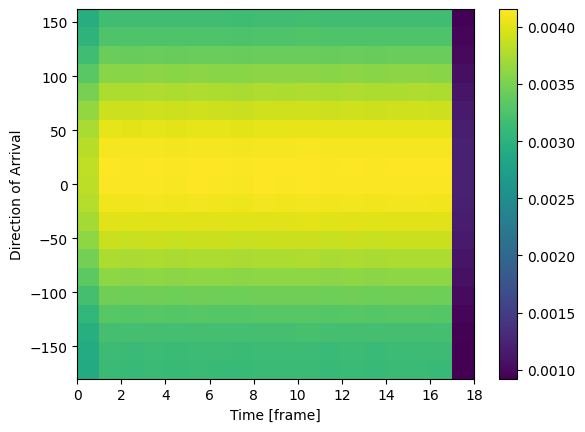

In [38]:
# 方向をスキャンするコードを生成
# マイクの位置を0としたシミュレーションの音声波形を生成
# スキャンしたスペクトルを描画->スペクトルはどの値をとる？
#    ->音のアレイ信号処理 p.103より、スペクトルはステアリング方向を変化させたときの各角度についての平均出力パワーをスペクトルとすればいいらしい。
import numpy as np

angles = np.linspace(-np.pi, np.pi, 20+1)
doas = np.hstack((np.full((angles.size-1, 1), np.pi/2.), angles[:20, None]))

sample_rate = 16000
N = 1024 # フレームサイズ
Nk = N / 2 + 1
freqs = np.arange(0, Nk, 1) * sample_rate / N

# 音源位置候補の方向20個を計算
source_locations = np.zeros((3, doas.shape[0]), dtype=doas.dtype)

source_locations[0, :] = np.cos(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[1, :] = np.sin(doas[:, 1]) * np.sin(doas[:, 0])
source_locations[2, :] = np.cos(doas[:, 0])
source_locations *= distance

source_locations += mic_array_loc[:, None]
# print("source_locations: \n", source_locations)

# ステアリングベクトルを計算
# 音源数であるsが20個あり、これが方向に対応する
far_steering_vectors = calculate_steering_vector(R, source_locations, freqs, sound_speed=340, is_use_far=True)

multi_conv_data = room.mic_array.signals # 時間領域でデータを取得 shapeは(M, 時間インデックス数)
print("multi_conv_data.shape", multi_conv_data.shape)
write_file_from_time_signal(multi_conv_data[0] * np.iinfo(np.int16).max/20., "./mix_in.wav", sample_rate)

f,t,stft_data = sp.stft(multi_conv_data, fs=sample_rate, window="hann", nperseg=N)

s_hat = np.einsum("ksm,mkt->skt", np.conjugate(far_steering_vectors), stft_data)
c_hat = np.einsum("skt,ksm->mskt", s_hat, far_steering_vectors)

t, ds_out = sp.istft(c_hat[0], fs=sample_rate, window="hann", nperseg=N)
ds_out = ds_out*np.iinfo(np.int16).max/20.
# write_file_from_time_signal(ds_out, "./ds_out.wav", sample_rate)

# 空間スペクトル1つを生成するためのフレーム数
frame_num = 10

# 空間スペクトルを算出・描画
display_DSBF_spectrum(stft_data, far_steering_vectors, start_angle=-180., end_angle=162., divisions=20, frame_num=10)



In [1]:

"""
E[]の期待値表現は、信号処理分野では基本的に時間平均で考えて良い
P(θ_T)の式→各周波数ビンごとに考える、平均はしない

周波数帯域をしぼる　または　各周波数ビンをnormalization
ただし、音が小さい部分は信頼性が低いとも考えられるので、使わないという考えもある

ピークを探すだけではうまくいかない
ピークの位置だけだではなく、他の角度の情報も考慮に入れる

音源定位に置いて、和を取るのはピークを取るためだった
ただし、回折音なのか直接音なのかは和を取ってしまうと情報が消えてしまう可能性がある
→パターンとして扱ったほうがいい　周波数ビンごとに違いが出るかも
（高い周波数は減衰しやすい、低い周波数は遠くまで届きやすいため）

注意点　周波数は音源に依存する
ノーマライズするかは試行錯誤する
音の情報がロストするのでは→しかし、それも元の音源の大きさに依存する
時間変化を考えるのも良いかも知れない

入力にする「差分」とは？
→空間スペクトルマップの差分
元の空間スペクトルを使うより、「時間的な変化」に着目するためより顕著に変化が見られるのではないか、という仮説
→時間変化を取るためにノーマライズしていいのか？
　比較する区間内全体でノーマライズすればOK

最初にながすのは定常信号とかホワイトノイズ？
ホワイトノイズは周波数特性がフラット（全周波数領域を均等に含む）
→音源の周波数特性に左右されなくて済む


スピーカーは周波数特性がフラットなもの、点音源がいい
アンプもいる
廊下はひろいほうがいい

1案：
角度と周波数のカラーマップをCNNに学習させてしまう

例えば、廊下の近く、奥、正面など　ラベルは位置

音はスピーカーで鳴らすか、人が声を発するか

Q. スペクトルの大きさとかの基準はあるのか？
→まずは元の音源の波形を見てみないことには始まらない

wave surfer

時間平均のフレーム数はパラメータなので考える必要がある
まずはアンプとスピーカーを探す→メールで確認
CNNについて学習する必要がある→分類問題として考える
調査も必要
  CNNのアーキテクチャについて調査する
"""




































# 加えて、音声信号ではなく定常信号を用いてシミュレーションした観測信号に対してビームフォーマを適用した結果がこちらになります。

# 画像

# 音源が存在する0度の方向がスペクトルの最高値の中心になっていることは確認できます。

'\nE[]の期待値表現は、信号処理分野では基本的に時間平均で考えて良い\nP(θ_T)の式→各周波数ビンごとに考える、平均はしない\n\n周波数帯域をしぼる\u3000または\u3000各周波数ビンをnormalization\nただし、音が小さい部分は信頼性が低いとも考えられるので、使わないという考えもある\n\nピークを探すだけではうまくいかない\nピークの位置だけだではなく、他の角度の情報も考慮に入れる\n\n音源定位に置いて、和を取るのはピークを取るためだった\nただし、回折音なのか直接音なのかは和を取ってしまうと情報が消えてしまう可能性がある\n→パターンとして扱ったほうがいい\u3000周波数ビンごとに違いが出るかも\n（高い周波数は減衰しやすい、低い周波数は遠くまで届きやすいため）\n\n注意点\u3000周波数は音源に依存する\nノーマライズするかは試行錯誤する\n音の情報がロストするのでは→しかし、それも元の音源の大きさに依存する\n時間変化を考えるのも良いかも知れない\n\n入力にする「差分」とは？\n→空間スペクトルマップの差分\n元の空間スペクトルを使うより、「時間的な変化」に着目するためより顕著に変化が見られるのではないか、という仮説\n\n最初にながすのは定常信号とかホワイトノイズ？\nホワイトノイズは周波数特性がフラット（全周波数領域を均等に含む）\n→音源の周波数特性に左右されなくて済む\n\n廊下はひろいほうがいい\n\n1案：\n角度と周波数のカラーマップをCNNに学習させてしまう\n\n例えば、廊下の近く、奥、正面など\u3000ラベルは位置\n\n音はスピーカーで鳴らすか、人が声を発するか\n\nQ. スペクトルの大きさとかの基準はあるのか？\n'